In [1]:
import pandas as pd
import numpy as np
import os
from scipy.io import wavfile
import matplotlib.pyplot as plt
import python_speech_features as psf
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [2]:
path = os.getcwd()
temp = path.split('/')
temp.pop(-1)
temp.pop(-1)  # remove it before the submission
temp.pop(-1)  # remove it before the submission
path = '/'.join(temp)
filename = '/data_v_7_stc/meta/meta.txt'

### Read meta file

In [3]:
meta = pd.read_csv(path + filename, sep="\t", header=None)
meta.columns = ["filename", "where", "something", "length", "label"]
meta.head(20)

,filename,where,something,length,label
0,background_0001.wav,office,0,9.458500,background
1,background_0001_time_stretch_0.wav,office,0,9.989070,background
2,background_0001_time_stretch_1.wav,office,0,9.879410,background
3,background_0001_time_stretch_10.wav,office,0,11.156553,background
4,background_0001_time_stretch_11.wav,office,0,13.261587,background
5,background_0001_time_stretch_12.wav,office,0,9.186440,background
6,background_0001_time_stretch_13.wav,office,0,8.117642,background
7,background_0001_time_stretch_2.wav,office,0,12.337098,background
8,background_0001_time_stretch_3.wav,office,0,12.455147,background
9,background_0001_time_stretch_4.wav,office,0,7.765306,background


In [4]:
print(meta["label"].unique(), meta["label"].nunique())
# meta["label"].isnull().sum()
meta["label"][meta["label"] == 'ring'].count()
# door = 3416
# ring = 713
# speech = 276

['background' 'bags' 'door' 'keyboard' 'knocking_door' 'ring' 'speech'
 'tool'] 8


713

### Open file

In [5]:
fs, data = wavfile.read(path + '/data_v_7_stc/audio/' + meta["filename"].loc[13])

print(len(data) / meta.length.loc[11])
# meta["filename"].loc[2]
print(fs)

14526.8461246
22050


In [32]:
meta.shape

(11307, 5)

<function matplotlib.pyplot.show(*args, **kw)>

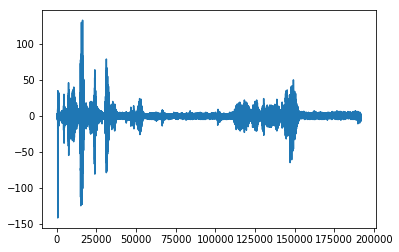

In [7]:
plt.plot(data)
plt.show

In [8]:
def pick_n_each(df, n, shuffle):
    df = df.sample(frac=1).reset_index(drop=True)
    res = pd.DataFrame(columns=df.columns)
    for label in df["label"].unique():
        res = res.append(df[df.label == label].iloc[0:n])
    if shuffle:
        return res.sample(frac=1).reset_index(drop=True)
    return res

In [33]:
N = 10
small = pick_n_each(meta, N, True)
test = pick_n_each(meta, N, True)

### Create feature vectors

In [34]:
# two types of features - mfcc or logfbank
mfcc = psf.mfcc(data, samplerate=fs, nfft=1024, nfilt=40, numcep=20)
logfbank = psf.logfbank(data, samplerate=fs, nfft=1024, nfilt=40)

# normalize
mfcc -= (np.mean(mfcc, axis=0) + 1e-8)
logfbank -= (np.mean(logfbank, axis=0) + 1e-8)

print('MFCC shape:', mfcc.shape)
print('Logfbank shape:', logfbank.shape)

MFCC shape: (868, 20)
Logfbank shape: (868, 40)


<function matplotlib.pyplot.show(*args, **kw)>

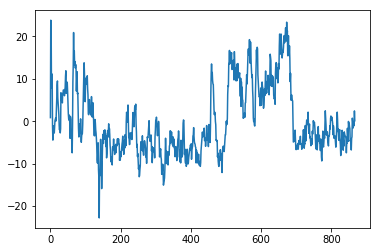

In [35]:
plt.plot(mfcc[:, 1])
plt.show

In [36]:
# add a column with a feature vectors
def make_fv(record):
    # load file
    fs, data = wavfile.read(path + '/data_v_7_stc/audio/' + record)
    mfcc_feature = psf.mfcc(data, samplerate=fs, nfft=1024, nfilt=40, numcep=20)
    return mfcc_feature
    

small['features'] = small.filename.apply(lambda x: make_fv(x))
test['features'] = test.filename.apply(lambda x: make_fv(x))

In [37]:
small.head()

,filename,where,something,length,label,features
0,k_0004_time_stretch_2.wav,office,0,27.184989,keyboard,"[[8.78827175602, -8.73434696959, 3.19859405147..."
1,speech_0057.wav,office,0,3.510500,speech,"[[4.0354589361, -45.5637144021, -25.4809190649..."
2,background_0016_time_stretch_2.wav,office,0,3.249388,background,"[[5.12110316918, -40.1004554994, -9.0956922433..."
3,d_0072_time_stretch_9.wav,office,0,0.680726,door,"[[16.9722742265, -12.5090906003, -47.077551482..."
4,k_0099_time_stretch_2.wav,office,0,2.345986,keyboard,"[[11.9464397703, -4.68769433214, -14.172056392..."


### Build an LSTM-classifier

In [38]:
from keras.optimizers import SGD
np.random.seed(14)
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
# from SpeechResearch import loadData

# 'exception_verbosity = high'
batch_size = 5
hidden_units = 20
nb_classes = 8
# print('Loading data...')
# (X_train, y_train), (X_test, y_test) = loadData.load_mfcc(10, 2)
X_train, Y_train = small.features, small.label
X_test, Y_test = test.features, test.label

# pad sequence
X_train = pad_sequences(X_train)
X_test = pad_sequences(X_test)
print('Vectors are padded')

Y_train = pd.get_dummies(Y_train)
Y_test = pd.get_dummies(Y_test)

print(len(X_train), 'train sequences')
print('Build model...')

model = Sequential()
model.add(LSTM(output_dim=hidden_units, init='uniform', inner_init='uniform',
               forget_bias_init='one', activation='tanh', inner_activation='sigmoid', input_shape=X_train.shape[1:]))

model.add(Dense(nb_classes))
model.add(Activation('softmax'))

sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd)

print("Train...")
model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=2)


score, acc = model.evaluate(X_test, Y_test,
                            batch_size=batch_size,
                            verbose=1)
print('Test score:', score)
print('Test accuracy:', acc)

Vectors are padded
80 train sequences
Build model...


/home/anton/miniconda3/envs/workenv/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(activation="tanh", input_shape=(5999, 20), unit_forget_bias=True, units=20, kernel_initializer="uniform", recurrent_initializer="uniform", recurrent_activation="sigmoid")`


Train...


/home/anton/miniconda3/envs/workenv/lib/python3.6/site-packages/keras/models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/2
80/80 [==============================] - 192s 2s/step - loss: 2.1155
Epoch 2/2
80/80 [==============================] - 188s 2s/step - loss: 2.0288


TypeError: evaluate() got an unexpected keyword argument 'show_accuracy'

In [39]:
acc = model.evaluate(X_test, Y_test,
                            batch_size=batch_size,
                            verbose=1)
print('Test score:', acc)

80/80 [==============================] - 15s 191ms/step
Test score: 1.91617269814


In [40]:
pred = model.predict(X_test, verbose=1)
pd.DataFrame(pred)

80/80 [==============================] - 3s 42ms/step


,0,1,2,3,4,5,6,7
0,0.421262,0.104229,0.149226,0.102740,0.122791,0.015065,0.014611,0.070076
1,0.184199,0.137796,0.009413,0.010891,0.150111,0.107499,0.060965,0.339126
2,0.139585,0.217391,0.208734,0.239912,0.087126,0.026470,0.016175,0.064607
3,0.106403,0.214606,0.026712,0.024030,0.077017,0.140727,0.062051,0.348454
4,0.139578,0.217495,0.208562,0.239940,0.086883,0.026535,0.016190,0.064818
5,0.175503,0.258538,0.069200,0.033840,0.206902,0.034580,0.067310,0.154127
6,0.137704,0.118699,0.075655,0.009351,0.068592,0.127278,0.209938,0.252784
7,0.297246,0.123953,0.223680,0.143854,0.116803,0.018951,0.015709,0.059805
8,0.175251,0.242812,0.128989,0.211935,0.064441,0.050614,0.014220,0.111738
9,0.177080,0.245044,0.128362,0.210870,0.063234,0.050640,0.013736,0.111034


In [41]:
Y_test

,background,bags,door,keyboard,knocking_door,ring,speech,tool
0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0
2,0,0,0,1,0,0,0,0
3,0,1,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0
5,0,0,0,0,0,0,1,0
6,0,0,0,0,0,0,1,0
7,0,0,0,0,0,0,0,1
8,0,0,0,1,0,0,0,0
9,0,0,1,0,0,0,0,0


In [259]:
tmp = X_train.as_matrix()
# x_train => (100, 99, 13) => [[frame1 frame2 .... frame99],[frame1 frame2 .... frame99]]
# y_train => (100,)
X_train[2].shape

/home/anton/miniconda3/envs/workenv/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


### Pad sequences

In [16]:
from keras.preprocessing.sequence import pad_sequences
# define sequences
# sequences = [
# 	[1, 2, 3, 4],
# 	   [1, 2, 3],
# 		     [1]
# 	]

sequences = X_train

# pad sequence
padded = pad_sequences(sequences)
print(padded)
padded.shape

[[[  0   0   0 ...,   0   0   0]
  [  0   0   0 ...,   0   0   0]
  [  0   0   0 ...,   0   0   0]
  ..., 
  [ 12 -16  -8 ...,  -2   1   3]
  [ 12 -14  -5 ...,   4   4   3]
  [ 12 -13 -10 ...,   1   2  -1]]

 [[  0   0   0 ...,   0   0   0]
  [  0   0   0 ...,   0   0   0]
  [  0   0   0 ...,   0   0   0]
  ..., 
  [  8 -32 -12 ...,  -2  -5   0]
  [  8 -34 -13 ...,   3   1   1]
  [  8 -30  -7 ...,   5  -1  -4]]

 [[  0   0   0 ...,   0   0   0]
  [  0   0   0 ...,   0   0   0]
  [  0   0   0 ...,   0   0   0]
  ..., 
  [ 13 -30 -34 ...,   0 -10   2]
  [ 12 -22 -27 ...,  -6  -8   3]
  [ 11 -31 -29 ...,  -5  -9   2]]

 ..., 
 [[  0   0   0 ...,   0   0   0]
  [  0   0   0 ...,   0   0   0]
  [  0   0   0 ...,   0   0   0]
  ..., 
  [ 12  -9 -61 ..., -13   7  -4]
  [ 11 -16 -54 ...,  -4  10  -3]
  [ 10 -27 -23 ...,  -1   3   1]]

 [[  0   0   0 ...,   0   0   0]
  [  0   0   0 ...,   0   0   0]
  [  0   0   0 ...,   0   0   0]
  ..., 
  [  5 -33 -17 ...,  -2  -3   3]
  [  5 -34 -18 ...,  

### Make dummy target

In [18]:
pd.get_dummies(Y_train)

,background,bags,door,keyboard,knocking_door,ring,speech,tool
0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,1,0
4,0,0,0,0,0,1,0,0
5,0,0,0,1,0,0,0,0
6,0,0,0,0,0,1,0,0
7,0,0,0,0,0,0,0,1
8,0,0,1,0,0,0,0,0
9,0,0,1,0,0,0,0,0
